# 1. IMPORTS / SETUP

In [10]:
import os
import sys
from starter import Starter

starter = Starter()
starter.start(lambda: os.chdir(os.path.join(os.getcwd(), '..')))


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Bidirectional, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, f1_score
import json
import time
import random
from typing import Dict, List, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
def reseed():
    np.random.seed(42)
    tf.random.set_seed(42)
    tf.keras.utils.set_seed(42)
    random.seed(42)

from utils.data_loader import DataLoader
from utils.metrics_calculator import MetricsCalculator
from models.rnn import RNNModelBuilder
from playgrounds.starter import Starter

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

Starter has already been initialized.


# 2. LOADING AND PREPROCESSING DATA

In [11]:
#!/usr/bin/env python3

# Initialize data loader
data_dir = "../data"  # Adjust path as needed
data_loader = DataLoader(data_dir)

# Load and prepare data
try:
    X_train, y_train, X_valid, y_valid, X_test, y_test = data_loader.prepare_data(
        max_vocab_size=5000,
        max_length=50,
    )
    
    print(f"\nData loaded successfully!")
    print(f"Vocabulary size: {data_loader.preprocessor.vocab_size}")
    print(f"Number of classes: {data_loader.num_classes}")
    print(f"Max sequence length: {data_loader.preprocessor.max_length}")
    
    # Show class distribution
    unique, counts = np.unique(y_train, return_counts=True)
    print(f"\nClass distribution in training data:")
    for class_id, count in zip(unique, counts):
        class_name = data_loader.reverse_label_encoder[class_id]
        print(f"  {class_name}: {count} ({count/len(y_train)*100:.1f}%)")
        
    print(f"\nData shapes:")
    print(f"  Training: X={X_train.shape}, y={y_train.shape}")
    print(f"  Validation: X={X_valid.shape}, y={y_valid.shape}")
    print(f"  Test: X={X_test.shape}, y={y_test.shape}")
    
    # Display sample data
    print(f"\n Sample data:")
    print(f"  First training text tokens: {X_train[0][:10]}...")
    print(f"  First training label: {y_train[0]} ({data_loader.reverse_label_encoder[y_train[0]]})")
    
    # Verify data integrity
    print(f"\nData integrity checks:")
    print(f"  No missing values in X_train: {not np.any(np.isnan(X_train))}")
    print(f"  No missing values in y_train: {not np.any(np.isnan(y_train))}")
    print(f"  All labels in valid range: {np.all((y_train >= 0) & (y_train < data_loader.num_classes))}")
    
    print(f"\nData preprocessing completed successfully!")
        
except Exception as e:
    print(f"Error loading data: {e}")
    import traceback
    traceback.print_exc()
    raise e

Loaded data:
  Train: 500 samples
  Valid: 100 samples
  Test: 400 samples
Keras vectorizer vocabulary size: 2836
Sample vocabulary: ['', '[UNK]', np.str_('yang'), np.str_('di'), np.str_('dan'), np.str_('tidak'), np.str_('saya'), np.str_('dengan'), np.str_('enak'), np.str_('ini')]

Data shapes:
  X_train: (500, 50)
  y_train: (500,)
  X_valid: (100, 50)
  y_valid: (100,)
  X_test: (400, 50)
  y_test: (400,)

Data loaded successfully!
Vocabulary size: 2836
Number of classes: 3
Max sequence length: 50

Class distribution in training data:
  negative: 192 (38.4%)
  neutral: 119 (23.8%)
  positive: 189 (37.8%)

Data shapes:
  Training: X=(500, 50), y=(500,)
  Validation: X=(100, 50), y=(100,)
  Test: X=(400, 50), y=(400,)

 Sample data:
  First training text tokens: [1758 1080 1145  196 2834  198   11  607  177  847]...
  First training label: 1 (neutral)

Data integrity checks:
  No missing values in X_train: True
  No missing values in y_train: True
  All labels in valid range: True

Dat

# 3. SETUP EXPERIMENT RUNNER

In [12]:
#!/usr/bin/env python3

class KerasRNNExperiment:
    """Keras RNN experiment class for systematic hyperparameter analysis"""
    
    def __init__(self, data_loader, X_train, y_train, X_valid, y_valid, X_test, y_test):
        self.data_loader = data_loader
        self.X_train = X_train
        self.y_train = y_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.X_test = X_test
        self.y_test = y_test
        
        # Base configuration
        self.base_config = {
            'vocab_size': data_loader.preprocessor.vocab_size,
            'embedding_dim': 64,
            'rnn_units': 32,
            'num_classes': data_loader.num_classes,
            'max_length': data_loader.preprocessor.max_length,
            'activation': 'tanh',
            'dropout_rate': 0.2,
            'learning_rate': 0.001,
            'batch_size': 32,
            'epochs': 15  # Increased for better training
        }
        
        print(f"Base configuration:")
        for key, value in self.base_config.items():
            print(f"  {key}: {value}")
    
    def create_keras_model(self, config):
        """Create Keras RNN model with given configuration"""
        model = Sequential()
        
        # Embedding layer
        model.add(Embedding(
            input_dim=config['vocab_size'],
            output_dim=config['embedding_dim'],
            input_length=config['max_length'],
            name='embedding'
        ))
        
        # RNN layers
        for i in range(config['num_rnn_layers']):
            return_sequences = i < config['num_rnn_layers'] - 1
            
            rnn_layer = SimpleRNN(
                config['rnn_units'],
                activation=config['activation'],
                return_sequences=return_sequences,
                name=f'simple_rnn_{i}'
            )
            
            if config['bidirectional']:
                model.add(Bidirectional(rnn_layer, name=f'bidirectional_rnn_{i}'))
            else:
                model.add(rnn_layer)
            
            # Add dropout after each RNN layer except the last
            if i < config['num_rnn_layers'] - 1:
                model.add(Dropout(config['dropout_rate'], name=f'dropout_{i}'))
        
        # Final dropout and classification layer
        model.add(Dropout(config['dropout_rate'], name='dropout_final'))
        model.add(Dense(config['num_classes'], activation='softmax', name='classification'))
        
        # Build model with proper input shape
        model.build(input_shape=(None, config['max_length']))
        
        # Compile model
        model.compile(
            optimizer=Adam(learning_rate=config['learning_rate']),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        
        return model
    
    def train_and_evaluate(self, config, experiment_name):
        """Train and evaluate a single configuration - FIXED VERSION"""
        print(f"\n{'='*60}")
        print(f"Training: {experiment_name}")
        print(f"Config: {config}")
        print(f"{'='*60}")
        
        start_time = time.time()
        
        # Create model
        model = self.create_keras_model(config)
        print(f"Model created with {model.count_params():,} parameters")
        
        # Train model with validation monitoring
        print(f"Starting training for {config['epochs']} epochs...")
        history = model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_valid, self.y_valid),
            epochs=config['epochs'],
            batch_size=config['batch_size'],
            verbose=1,
            callbacks=[
                tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    patience=5,
                    restore_best_weights=True
                )
            ]
        )
        
        # Evaluate on test set
        print(f"Evaluating on test set...")
        test_loss, test_acc = model.evaluate(self.X_test, self.y_test, verbose=0)
        test_predictions = model.predict(self.X_test, verbose=0)
        test_pred_classes = np.argmax(test_predictions, axis=1)
        
        # Calculate macro F1-score
        test_f1_macro = f1_score(self.y_test, test_pred_classes, average='macro')
        
        # Also evaluate on validation set for consistency
        valid_predictions = model.predict(self.X_valid, verbose=0)
        valid_pred_classes = np.argmax(valid_predictions, axis=1)
        valid_f1_macro = f1_score(self.y_valid, valid_pred_classes, average='macro')
        
        # Save weights for from-scratch comparison
        weights_path = f"results/{experiment_name}_weights.npz"
        os.makedirs("results", exist_ok=True)
        self.save_keras_weights(model, weights_path, config)
        
        training_time = time.time() - start_time
        
        print(f"\n Results for {experiment_name}:")
        print(f"   Training time: {training_time:.2f} seconds")
        print(f"   Test Accuracy: {test_acc:.4f}")
        print(f"   Test F1-Score (macro): {test_f1_macro:.4f}")
        print(f"   Valid F1-Score (macro): {valid_f1_macro:.4f}")
        print(f"   Weights saved to: {weights_path}")
        
        return {
            'model': model,
            'history': history.history,
            'test_accuracy': test_acc,
            'test_f1_score': test_f1_macro,
            'valid_f1_score': valid_f1_macro,
            'weights_path': weights_path,
            'config': config,
            'training_time': training_time
        }
    
    def save_keras_weights(self, model, filepath, config):
        """Save Keras weights in format compatible with from-scratch model - FIXED VERSION"""
        print(f"Saving Keras weights to: {filepath}")
        
        try:
            # Verify model has weights
            if len(model.weights) == 0:
                raise ValueError("Model has no weights to save!")
            
            weights_dict = {}
            rnn_layer_count = 0
            
            for layer in model.layers:
                layer_weights = layer.get_weights()
                if len(layer_weights) == 0:
                    continue
                    
                layer_name = layer.name
                print(f"  Processing layer: {layer_name} - {len(layer_weights)} weight arrays")
                
                if 'embedding' in layer_name.lower():
                    weights_dict['embedding'] = {
                        'embedding_matrix': layer_weights[0]
                    }
                elif 'simple_rnn' in layer_name.lower():
                    target_name = f'rnn_{rnn_layer_count}'
                    weights_dict[target_name] = {
                        'W_ih': layer_weights[0].T,  # Transpose for our convention
                        'W_hh': layer_weights[1].T,  # Transpose for our convention
                        'b_h': layer_weights[2]
                    }
                    rnn_layer_count += 1
                elif 'bidirectional' in layer_name.lower():
                    target_name = f'bidirectional_rnn_{rnn_layer_count}'
                    if len(layer_weights) >= 6:
                        weights_dict[target_name] = {
                            'forward_W_ih': layer_weights[0].T,
                            'forward_W_hh': layer_weights[1].T,
                            'forward_b_h': layer_weights[2],
                            'backward_W_ih': layer_weights[3].T,
                            'backward_W_hh': layer_weights[4].T,
                            'backward_b_h': layer_weights[5]
                        }
                    rnn_layer_count += 1
                elif 'dense' in layer_name.lower() or 'classification' in layer_name.lower():
                    weights_dict['classification'] = {
                        'W': layer_weights[0].T,  # Transpose for our convention
                        'b': layer_weights[1]
                    }
            
            # Save weights
            save_dict = {}
            for layer_name, layer_weights in weights_dict.items():
                for weight_name, weight_value in layer_weights.items():
                    save_dict[f"{layer_name}_{weight_name}"] = weight_value
            
            # Also save configuration for reference
            save_dict['config'] = json.dumps(config)
            
            np.savez(filepath, **save_dict)
            print(f" Saved {len(save_dict)-1} weight arrays successfully")
            print(f" Layers saved: {list(weights_dict.keys())}")
            
            # Verify save
            loaded_check = np.load(filepath)
            assert len(loaded_check.files) == len(save_dict), "Save verification failed"
            loaded_check.close()
            
        except Exception as e:
            print(f"Error saving weights: {e}")
            import traceback
            traceback.print_exc()
            raise

# Initialize experiment runner
print("Initializing Keras experiment framework...")
keras_experiment = KerasRNNExperiment(
    data_loader, X_train, y_train, X_valid, y_valid, X_test, y_test
)
print("Keras experiment runner initialized!")

Initializing Keras experiment framework...
Base configuration:
  vocab_size: 2836
  embedding_dim: 64
  rnn_units: 32
  num_classes: 3
  max_length: 50
  activation: tanh
  dropout_rate: 0.2
  learning_rate: 0.001
  batch_size: 32
  epochs: 15
Keras experiment runner initialized!


# 4. EXPERIMENTS

## 4.1. Comparing Layer Counts

In [13]:
#!/usr/bin/env python3
layer_counts = [1, 3, 5]
layer_results = {}

for num_layers in layer_counts:
    config = keras_experiment.base_config.copy()
    config.update({
        'num_rnn_layers': num_layers,
        'bidirectional': True, 
        'rnn_units': 64
    })
    # config['epochs'] = 10
    
    experiment_name = f"rnn_layers_{num_layers}"
    print(f"\n🔬 Experiment: {experiment_name}")
    print(f"   Layers: {num_layers}, Units: {config['rnn_units']}, Bidirectional: {config['bidirectional']}")
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name)
        for k,v in result.items():
            print(k, v)
        layer_results[num_layers] = result
        print(f" {experiment_name} completed successfully!")
    except Exception as e:
        print(f" Error in {experiment_name}: {e}")
        continue

print(f"{'Layers':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for layers in sorted(layer_results.keys()): 
    result = layer_results[layers]
    print(f"{layers:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")



🔬 Experiment: rnn_layers_1
   Layers: 1, Units: 64, Bidirectional: True

Training: rnn_layers_1
Config: {'vocab_size': 2836, 'embedding_dim': 64, 'rnn_units': 64, 'num_classes': 3, 'max_length': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'num_rnn_layers': 1, 'bidirectional': True}
Model created with 198,403 parameters
Starting training for 15 epochs...
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.3897 - loss: 1.0646 - val_accuracy: 0.5000 - val_loss: 1.0620
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5964 - loss: 0.8870 - val_accuracy: 0.5000 - val_loss: 0.9720
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7530 - loss: 0.6330 - val_accuracy: 0.5300 - val_loss: 0.9654
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9322 - loss: 0.3376 - val_accuracy: 0.5900 - val_loss: 0.9548
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9625 - loss

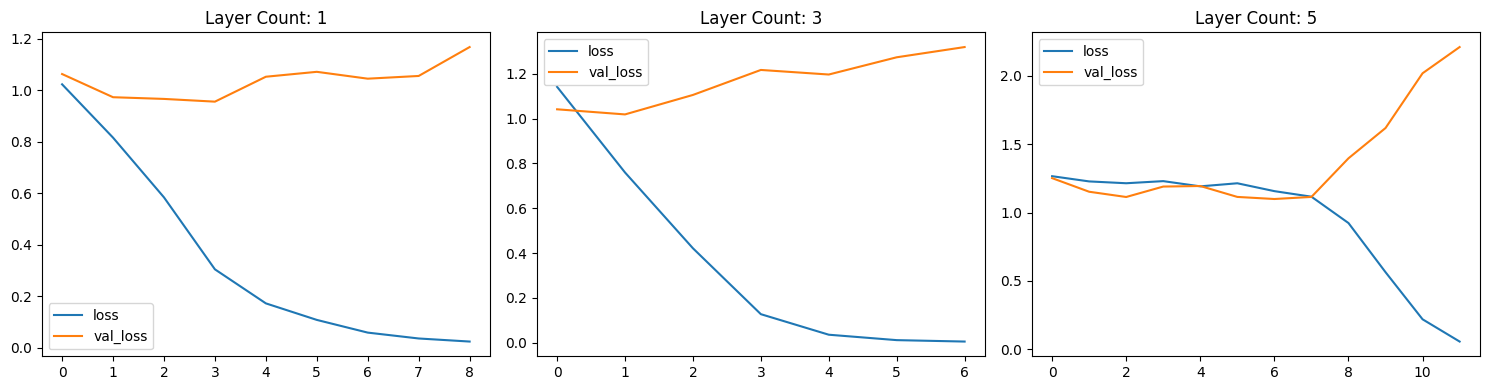

In [14]:
import math

columns = 3
total_plots = len(layer_results)
rows = math.ceil(total_plots / columns)
fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows))
axes = axes.flatten()

for idx, (layer_count, L) in enumerate(sorted(layer_results.items())):
    ax = axes[idx]
    ax.plot(L['history']['loss'], label='loss')
    ax.plot(L['history']['val_loss'], label='val_loss')
    ax.set_title(f'Layer Count: {layer_count}')
    ax.legend()

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 4.2. Comparing Cell Counts

In [15]:
#!/usr/bin/env python3
cell_counts = [16, 64, 128, 256]
cell_results = {}

for num_cells in cell_counts:
    config = keras_experiment.base_config.copy()
    config.update({
        'num_rnn_layers': 1,
        'bidirectional': True, 
        'rnn_units': num_cells
    })
    experiment_name = f"rnn_cells_{num_cells}"
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name)
        cell_results[num_cells] = result
        print(f" {experiment_name} completed successfully!")
    except Exception as e:
        print(f" Error in {experiment_name}: {e}")
        continue

print(f"{'Cells':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for cells in sorted(cell_results.keys()):
    result = cell_results[cells]
    print(f"{cells:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")
    


Training: rnn_cells_16
Config: {'vocab_size': 2836, 'embedding_dim': 64, 'rnn_units': 16, 'num_classes': 3, 'max_length': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'num_rnn_layers': 1, 'bidirectional': True}
Model created with 184,195 parameters
Starting training for 15 epochs...
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.3895 - loss: 1.1027 - val_accuracy: 0.5000 - val_loss: 1.0213
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6747 - loss: 0.8371 - val_accuracy: 0.5400 - val_loss: 0.9657
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8440 - loss: 0.6073 - val_accuracy: 0.6100 - val_loss: 0.9036
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9268 - loss: 0.4213 - val_accuracy: 0.5900 - val_loss: 0.9349
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9516 - loss: 0.3019 - val_accuracy: 0.4900 - val_loss: 1.0683
Epoch 6/15
16/16 ━━━━━

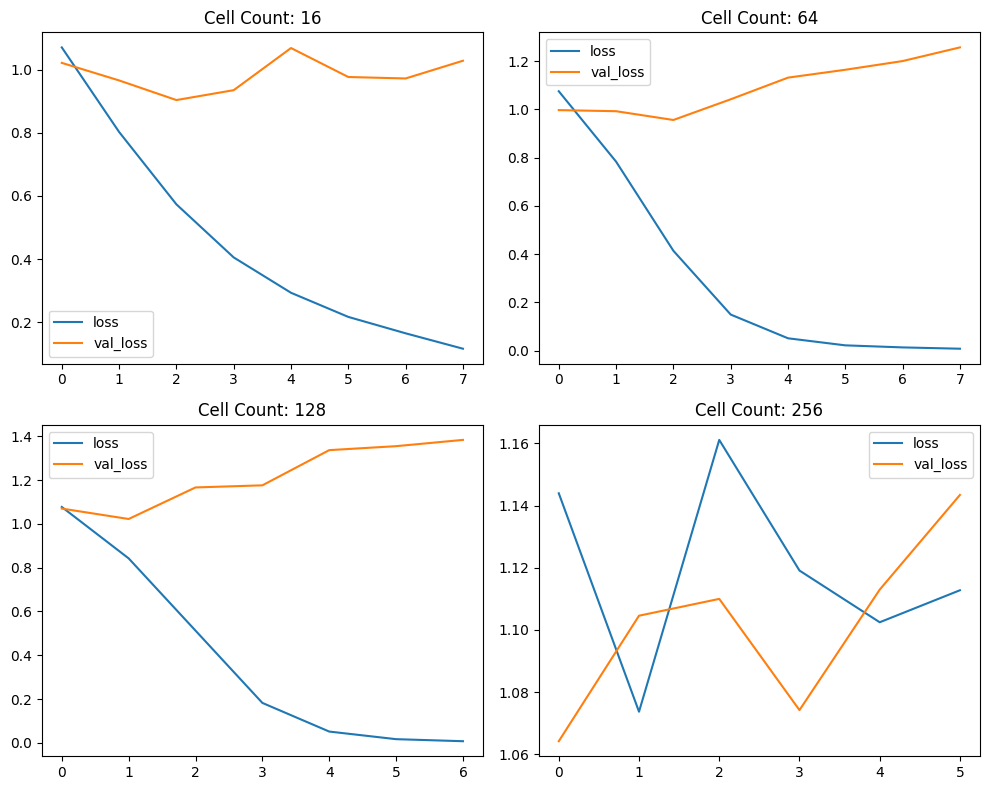

In [16]:
import math

columns = 2
total_plots = len(cell_results)
rows = math.ceil(total_plots / columns)
fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows))
axes = axes.flatten()

for idx, (cell_count, L) in enumerate(sorted(cell_results.items())):
    ax = axes[idx]
    ax.plot(L['history']['loss'], label='loss')
    ax.plot(L['history']['val_loss'], label='val_loss')
    ax.set_title(f'Cell Count: {cell_count}')
    ax.legend()

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## 4.3. Comparing Bidirectional vs. Unidirectional

In [17]:
#!/usr/bin/env python3
ltype_results = {}
ltype_vars = [False, True]

for ltype in ltype_vars:
    config = keras_experiment.base_config.copy()
    config.update({
        'num_rnn_layers': 1,
        'bidirectional': ltype, 
        'rnn_units': 64
    })
    experiment_name = f"rnn_ltypes_{'bidirectional' if ltype else 'not unidirectional'}"
    
    try:
        result = keras_experiment.train_and_evaluate(config, experiment_name)
        ltype_results[ltype] = result
        print(f" {experiment_name} completed successfully!")
    except Exception as e:
        print(f" Error in {experiment_name}: {e}")
        continue

print(f"{'ltypes':<8} {'Accuracy':<10} {'F1-Score':<10} {'Time (s)':<10}")
print("-"*40)
for ltypes in sorted(ltype_results.keys()):
    result = ltype_results[ltypes]
    print(f"{ltypes:<8} {result['test_accuracy']:.4f}    {result['test_f1_score']:.4f}    {result['training_time']:.1f}")



Training: rnn_ltypes_not unidirectional
Config: {'vocab_size': 2836, 'embedding_dim': 64, 'rnn_units': 64, 'num_classes': 3, 'max_length': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'num_rnn_layers': 1, 'bidirectional': False}
Model created with 189,955 parameters
Starting training for 15 epochs...
Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.4720 - loss: 1.0373 - val_accuracy: 0.5300 - val_loss: 0.9448
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6220 - loss: 0.8122 - val_accuracy: 0.5900 - val_loss: 0.8869
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7711 - loss: 0.7007 - val_accuracy: 0.6300 - val_loss: 0.8391
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9491 - loss: 0.3501 - val_accuracy: 0.6400 - val_loss: 0.8684
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9918 - loss: 0.1445 - val_accuracy: 0.6200 - val_loss: 0.9603
Epoch 

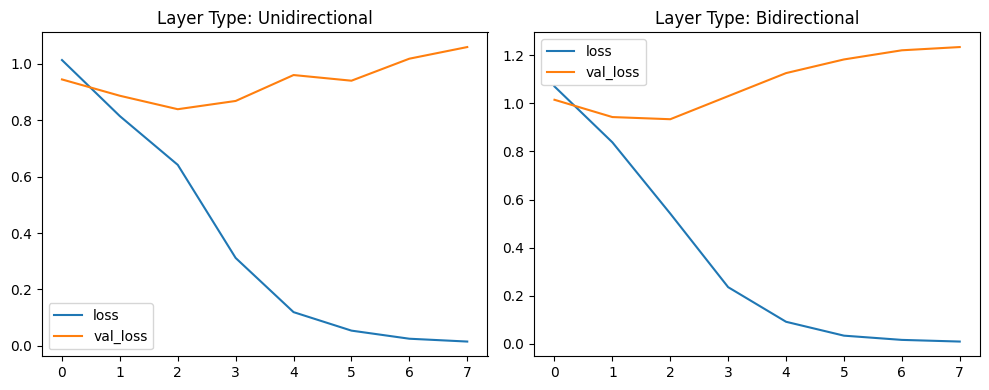

In [19]:
import math

columns = 2
total_plots = len(ltype_results)
rows = math.ceil(total_plots / columns)
fig, axes = plt.subplots(rows, columns, figsize=(5 * columns, 4 * rows))
axes = axes.flatten()

for idx, (ltype_var, L) in enumerate(sorted(ltype_results.items())):
    ax = axes[idx]
    ax.plot(L['history']['loss'], label='loss')
    ax.plot(L['history']['val_loss'], label='val_loss')
    ax.set_title(f"Layer Type: {'Bidirectional' if ltype_var else 'Unidirectional'}")
    ax.legend()

for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 5. COMPARE WITH FROM SCRATCH

In [20]:
#!/usr/bin/env python3
def compare_keras_vs_scratch(keras_result, experiment_name):
    """Compare Keras model with from-scratch implementation - Formal Version"""
    print(f"\nExperiment: {experiment_name.replace('_', ' ').title()}")
    print("-" * 50)

    try:
        keras_model = keras_result['model']
        config = keras_result['config']
        weights_path = keras_result['weights_path']

        print(f"Comparing experiment: {experiment_name}")
        print(f"Using configuration: {config}")
        print(f"Loading weights from: {weights_path}")

        if not os.path.exists(weights_path):
            raise FileNotFoundError(f"Weights file not found: {weights_path}")

        scratch_model = RNNModelBuilder.create_simple_rnn_model(
            vocab_size=config['vocab_size'],
            embedding_dim=config['embedding_dim'],
            rnn_units=config['rnn_units'],
            num_classes=config['num_classes'],
            num_rnn_layers=config['num_rnn_layers'],
            bidirectional=config['bidirectional'],
            dropout_rate=config['dropout_rate'],
            activation=config['activation']
        )

        print("From-scratch model summary:")
        print(scratch_model.summary())

        sample_input = X_test[:5]
        _ = scratch_model.forward(sample_input)
        print(f"Model built successfully with input shape: {sample_input.shape}")

        scratch_model.load_weights(weights_path)
        scratch_model.set_training(False)

        print(f"Comparing predictions on {len(X_test)} test samples...")

        keras_predictions = keras_model.predict(X_test, verbose=0)
        scratch_predictions = scratch_model.predict(X_test)

        print(f"Keras predictions shape: {keras_predictions.shape}")
        print(f"Scratch predictions shape: {scratch_predictions.shape}")

        if keras_predictions.shape != scratch_predictions.shape:
            raise ValueError(f"Shape mismatch: Keras {keras_predictions.shape} vs Scratch {scratch_predictions.shape}")

        keras_pred_classes = np.argmax(keras_predictions, axis=1)
        scratch_pred_classes = np.argmax(scratch_predictions, axis=1)

        keras_accuracy = np.mean(keras_pred_classes == y_test)
        scratch_accuracy = np.mean(scratch_pred_classes == y_test)

        keras_f1 = f1_score(y_test, keras_pred_classes, average='macro')
        scratch_f1 = f1_score(y_test, scratch_pred_classes, average='macro')

        max_diff = np.max(np.abs(keras_predictions - scratch_predictions))
        mean_diff = np.mean(np.abs(keras_predictions - scratch_predictions))
        similarity = np.mean(np.isclose(keras_predictions, scratch_predictions, atol=1e-5))

        print("\nComparison Results")
        print(f"{'Metric':<25} {'Keras':<12} {'From-Scratch':<12} {'Difference':<12}")
        print("-" * 63)
        print(f"{'Accuracy':<25} {keras_accuracy:<12.6f} {scratch_accuracy:<12.6f} {abs(keras_accuracy - scratch_accuracy):<12.6f}")
        print(f"{'F1-Score (macro)':<25} {keras_f1:<12.6f} {scratch_f1:<12.6f} {abs(keras_f1 - scratch_f1):<12.6f}")
        print(f"{'Max Prediction Diff':<25} {max_diff:<12.8f}")
        print(f"{'Mean Prediction Diff':<25} {mean_diff:<12.8f}")
        print(f"{'Prediction Similarity':<25} {similarity:<12.6f}")

        print("\nSample Predictions")
        for i in range(min(5, len(X_test))):
            print(f"Sample {i+1}:")
            print(f"  Keras:        {keras_predictions[i]}")
            print(f"  From-scratch: {scratch_predictions[i]}")
            print(f"  Difference:   {np.abs(keras_predictions[i] - scratch_predictions[i])}")
            print(f"  True label:   {y_test[i]} ({data_loader.reverse_label_encoder[y_test[i]]})")
            print(f"  Keras pred:   {keras_pred_classes[i]} ({data_loader.reverse_label_encoder[keras_pred_classes[i]]})")
            print(f"  Scratch pred: {scratch_pred_classes[i]} ({data_loader.reverse_label_encoder[scratch_pred_classes[i]]})")
            print()

        agreement_rate = np.mean(keras_pred_classes == scratch_pred_classes)
        f1_diff = abs(keras_f1 - scratch_f1)
        acc_diff = abs(keras_accuracy - scratch_accuracy)

        print("Additional Validation")
        print(f"Prediction agreement rate: {agreement_rate:.4f}")
        print(f"F1-score difference: {f1_diff:.6f}")
        print(f"Accuracy difference: {acc_diff:.6f}")

        return {
            'keras_accuracy': keras_accuracy,
            'scratch_accuracy': scratch_accuracy,
            'keras_f1': keras_f1,
            'scratch_f1': scratch_f1,
            'max_difference': max_diff,
            'mean_difference': mean_diff,
            'prediction_similarity': similarity,
            'agreement_rate': agreement_rate,
            'experiment_name': experiment_name
        }

    except Exception as e:
        print(f"Error occurred during comparison for {experiment_name}: {e}")
        import traceback
        traceback.print_exc()
        return {
            'keras_accuracy': 0.0,
            'scratch_accuracy': 0.0,
            'keras_f1': 0.0,
            'scratch_f1': 0.0,
            'max_difference': 999.0,
            'mean_difference': 999.0,
            'prediction_similarity': 0.0,
            'agreement_rate': 0.0,
            'experiment_name': experiment_name,
            'error': str(e)
        }

# Execution block

print("Comparing Keras vs From-Scratch Implementations Using Trained Models")

comparison_results = {}

if layer_results:
    best_layer_count_res = max(layer_results.values(), key=lambda v: v['test_f1_score'])
    comparison_results['layers'] = compare_keras_vs_scratch(best_layer_count_res, "layer counts")

if cell_results:
    best_cell_count_res = max(cell_results.values(), key=lambda v: v['test_f1_score'])
    comparison_results['units'] = compare_keras_vs_scratch(best_cell_count_res, "unit counts")

if ltype_results:
    best_direction_type_res = max(ltype_results.values(), key=lambda v: v['test_f1_score'])
    comparison_results['direction'] = compare_keras_vs_scratch(best_direction_type_res, "direction types")

print("\nSummary of Implementation Comparison")
print("=" * 60)
print(f"{'Experiment':<20} {'Max Diff':<12} {'F1 Diff':<10} {'Agreement':<10} {'Status':<15}")
print("-" * 75)

for category, result in comparison_results.items():
    if 'error' not in result:
        f1_diff = abs(result['keras_f1'] - result['scratch_f1'])
        print(f"{category:<20} {result['max_difference']:<12.6f} {f1_diff:<10.6f} {result['agreement_rate']:<10.4f} Valid")
    else:
        print(f"{category:<20} {'ERROR':<12} {'ERROR':<10} {'ERROR':<10} Failed")


Comparing Keras vs From-Scratch Implementations Using Trained Models

Experiment: Layer Counts
--------------------------------------------------
Comparing experiment: layer counts
Using configuration: {'vocab_size': 2836, 'embedding_dim': 64, 'rnn_units': 64, 'num_classes': 3, 'max_length': 50, 'activation': 'tanh', 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 15, 'num_rnn_layers': 1, 'bidirectional': True}
Loading weights from: results/rnn_layers_1_weights.npz
From-scratch model summary:
Model: SimpleRNN
embedding (EmbeddingLayer): vocab_size=2836, embedding_dim=64
bidirectional_rnn_0 (BidirectionalLayer): hidden_size=64
dropout_final (DropoutLayer): rate=0.2
classification (DenseLayer): units=3, activation=softmax
Model built successfully with input shape: (5, 50)
Loading weights from results/rnn_layers_1_weights.npz
Available keys in file: ['embedding_embedding_matrix', 'bidirectional_rnn_0_forward_W_ih', 'bidirectional_rnn_0_forward_W_hh', 'bidirectiona